In [1]:
import gurobipy as gp
from gurobipy import Model, GRB, quicksum
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import numpy as np
import seaborn as sns
from IPython.display import display
from matplotlib.ticker import MaxNLocator
import random

# === Problem Setup ===
n = 100  # Number of MAFs (tasks)
m = 5  # Number of processing units
K = 5  # Number of energy levels

L_levels = [20, 18, 12, 7, 3]  # Delay per energy level
E_levels = [10, 30, 40, 45, 120]   # Energy consumption per energy class
E_PU_max = [9000] * m  # Maximum energy consumption per processing unit
CPU_capacity = [2000] * m  # CPU resources per processing unit
f_v_levels = [20, 30, 40, 60, 80]  # CPU requirements for each MAF
C_total_max = 12000  # Total system resource capacity
P_idle = [18] * m  # Idle power consumption per PU
T_total = 400  # Total system execution time
P_max = [30] * m  # PU Full-load power consumption
# Task Chains
num_chains = 10
chain_tasks = {i: list(range(i * 10, (i + 1) * 10)) for i in range(num_chains)}
L_max = [200] * num_chains


In [2]:
# ✅ 增强 Greedy 实现：保持与 Gurobi 相同的约束，包括系统总资源限制 C_total_max

def run_heuristic_model_with_constraints(chain_enabled=None):
    delta = [0] * n
    y = [-1] * n  # -1 表示未分配能耗等级
    w = [-1] * n  # -1 表示未分配PU

    pu_remaining_cpu = CPU_capacity[:]
    pu_total_energy = [0] * m
    pu_workload = [0] * m
    total_cpu_used = 0
    accepted_chains = 0

    for k in range(num_chains):
        if chain_enabled and chain_enabled.get(k, 1) == 0:
            continue

        task_list = chain_tasks[k]
        chain_latency = 0
        chain_cpu = 0
        task_energy_levels = []
        task_cpu_usage = []

        # 为每个任务选择最低能耗等级，使得延迟可接受
        for i in task_list:
            for level in range(K):
                latency = L_levels[level]
                cpu = f_v_levels[level]
                if latency + (len(task_list)-1) <= L_max[k]:
                    task_energy_levels.append(level)
                    task_cpu_usage.append(cpu)
                    chain_latency += latency
                    chain_cpu += cpu
                    break
            else:
                break
        else:
            # 再加上总系统资源限制检查
            if total_cpu_used + chain_cpu > C_total_max:
                continue

            # 找一个能承载这条链任务的PU
            for j in range(m):
                if pu_remaining_cpu[j] >= chain_cpu:
                    for idx, i in enumerate(task_list):
                        delta[i] = 1
                        y[i] = task_energy_levels[idx]
                        w[i] = j
                        pu_remaining_cpu[j] -= task_cpu_usage[idx]
                        pu_workload[j] += L_levels[task_energy_levels[idx]]
                        total_cpu_used += task_cpu_usage[idx]
                    accepted_chains += 1
                    break

    # 计算总能耗
    maf_energy = sum(E_levels[y[i]] for i in range(n) if y[i] != -1)
    pu_energy = 0
    for j in range(m):
        workload_time = pu_workload[j]
        idle_time = T_total - workload_time
        energy = P_idle[j] * idle_time + (P_max[j] - P_idle[j]) * workload_time
        pu_energy += energy

    total_energy = maf_energy + pu_energy
    acceptance_rate = accepted_chains / num_chains
    objective = 2500 * sum(delta) - 10 * maf_energy - 1 * pu_energy

    return {
        "delta": delta,
        "w": w,
        "y": y,
        "objective": objective,
        "total_energy": total_energy,
        "acceptance_rate": acceptance_rate,
        "accepted_chains": accepted_chains,
        "maf_energy": maf_energy,
        "pu_energy": pu_energy
    }

MAF: 100, PU: 5, Time: 0.0003s
MAF: 500, PU: 25, Time: 0.0015s
MAF: 1000, PU: 50, Time: 0.0018s
MAF: 5000, PU: 250, Time: 0.0110s
MAF: 10000, PU: 500, Time: 0.0171s


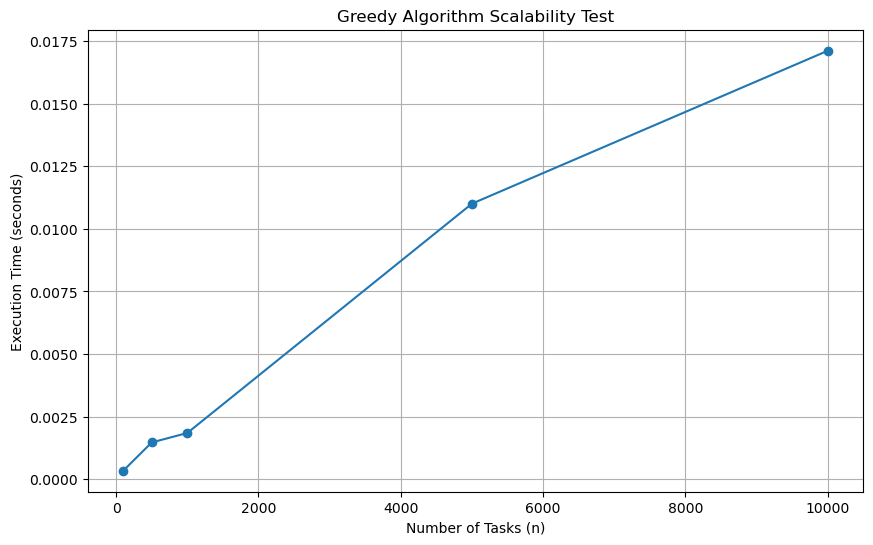

In [4]:
import time
import matplotlib.pyplot as plt

# 实验参数
n_values = [100, 500, 1000, 5000, 10000]
execution_times = []

for n_test in n_values:
    n = n_test
    m = n // 20  # PU数量按比例扩大
    K = 5
    
    L_levels = [20, 18, 12, 7, 3]
    E_levels = [10, 30, 40, 45, 120]
    CPU_capacity = [2000] * m
    f_v_levels = [20, 30, 40, 60, 80]
    
    # 按比例扩大资源限制
    C_total_max = 120 * n
    E_PU_max = [90 * n] * m
    P_idle = [18] * m
    P_max = [30] * m
    T_total = 400
    
    # 链结构
    num_chains = n // 10
    chain_tasks = {i: list(range(i * 10, (i + 1) * 10)) for i in range(num_chains)}
    L_max = [200] * num_chains
    
    start_time = time.perf_counter()
    run_heuristic_model_with_constraints()  # 调用你的Greedy方法
    elapsed = time.perf_counter() - start_time
    execution_times.append(elapsed)
    
    print(f"MAF: {n}, PU: {m}, Time: {elapsed:.4f}s")

# 绘制运行耗时曲线
plt.figure(figsize=(10, 6))
plt.plot(n_values, execution_times, marker='o', linestyle='-')
plt.title("Greedy Algorithm Scalability Test")
plt.xlabel("Number of Tasks (n)")
plt.ylabel("Execution Time (seconds)")
plt.grid(True)
plt.show()
